In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append('../../../marine/pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [3]:
import elitism

In [4]:
from scipy.spatial import ConvexHull

In [5]:
import networkx as nx

In [6]:
x0,y0 = 25, 80

# FEM Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

# Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 4000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0    

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    try:
        tmp, const = fast_stopt(args, x)
        if const>(60+binatodeci(individual[-4:]))/100:
            return PENALTY_VALUE, 
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [28]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [29]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).reshape(x0,y0)
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    

gen	nevals	min    	avg        
0  	300   	1519.41	1.30202e+06
1  	248   	1497.31	4709.67    
2  	252   	1391.11	2367.04    
3  	242   	1342.01	2836.64    
4  	248   	1321.37	1656.15    
5  	249   	1250.22	1536.82    
6  	244   	1244.01	1469.6     
7  	249   	1179.31	1407.72    
8  	254   	1135.04	1354.05    
9  	244   	1133.18	1292.18    
10 	257   	1072.74	1234.25    
11 	252   	1033.18	1194.59    
12 	237   	996.745	1153.91    
13 	239   	971.986	1119.52    
14 	259   	929.71 	1083.35    
15 	261   	901.267	1047.33    
16 	238   	871.115	1014.66    
17 	248   	871.115	979.001    
18 	241   	842.095	948.05     
19 	250   	810.035	922.704    
20 	240   	790.401	894.579    
21 	243   	788.055	866.384    
22 	247   	769.568	843.852    
23 	248   	769.554	825.501    
24 	237   	727.514	807.02     
25 	253   	712.223	796.165    
26 	240   	712.223	784.25     
27 	251   	697.962	770.029    
28 	237   	696.188	752.048    
29 	246   	678.486	736.415    
30 	252   	662.94 	719.93     
31 	250 

264	253   	368.881	371.009    
265	253   	368.24 	370.516    
266	248   	368.093	370.186    
267	244   	366.643	369.563    
268	232   	366.643	369.032    
269	246   	365.78 	368.569    
270	250   	365.743	368.117    
271	257   	364.874	367.614    
272	241   	364.356	366.937    
273	237   	363.4  	366.407    
274	232   	363.223	365.975    
275	246   	363.195	365.471    
276	250   	362.778	365.307    
277	245   	361.759	364.409    
278	240   	361.759	363.704    
279	233   	360.366	363.17     
280	253   	360.366	362.705    
281	261   	359.719	362.123    
282	240   	358.786	361.563    
283	259   	358.021	361.021    
284	245   	357.596	360.457    
285	254   	357.373	359.941    
286	243   	357.088	359.174    
287	253   	356.653	358.461    
288	241   	356.295	357.905    
289	241   	355.297	357.364    
290	247   	355.165	357.01     
291	243   	354.828	356.623    
292	243   	354.466	356.302    
293	239   	353.757	355.832    
294	240   	353.41 	355.452    
295	243   	352.642	354.994    
296	244 

529	251   	288.218	362.226    
530	245   	288.185	364.53     
531	241   	287.966	355.035    
532	248   	287.882	397.622    
533	255   	287.726	385.709    
534	238   	287.726	380.887    
535	249   	287.586	361.827    
536	237   	287.574	387.827    
537	249   	287.487	359.299    
538	240   	287.487	387.7      
539	245   	287.283	356.774    
540	243   	287.283	378.021    
541	243   	287.283	389.842    
542	252   	287.283	366.031    
543	245   	287.187	354.106    
544	243   	287.187	380.171    
545	251   	287.164	370.62     
546	258   	287.051	380.084    
547	242   	287.02 	384.797    
548	237   	287.02 	384.774    
549	257   	286.846	372.863    
550	241   	286.846	389.451    
551	232   	286.846	368.014    
552	243   	286.74 	379.905    
553	248   	286.74 	348.939    
554	244   	286.74 	360.743    
555	241   	286.693	372.594    
556	250   	286.693	372.554    
557	255   	286.599	398.696    
558	251   	286.599	384.423    
559	255   	286.431	396.571    
560	250   	286.296	381.967    
561	246 

794	252   	272.315	360.129    
795	251   	272.315	352.771    
796	244   	272.315	343.03     
797	246   	272.315	372.157    
798	255   	272.168	369.644    
799	249   	272.168	355.044    
800	241   	272.156	376.808    
801	246   	272.156	369.495    
802	241   	272.156	345.235    
803	255   	272.156	381.61     
804	244   	272.156	367.018    
805	254   	272.098	374.252    
806	248   	272.075	369.383    
807	253   	272.055	354.793    
808	248   	272.055	379.022    
809	251   	271.975	342.58     
810	228   	271.975	374.102    
811	239   	271.921	357.089    
812	248   	271.921	342.524    
813	240   	271.83 	330.382    
814	249   	271.83 	374.037    
815	245   	271.83 	354.642    
816	242   	271.83 	383.743    
817	242   	271.83 	371.589    
818	254   	271.799	369.153    
819	254   	271.762	359.419    
820	250   	271.762	383.802    
821	250   	271.723	383.672    
822	248   	271.601	361.761    
823	243   	271.601	376.296    
824	249   	271.594	373.919    
825	235   	271.594	386.014    
826	245 

1057	251   	266.506	376.815    
1058	232   	266.506	354.774    
1059	242   	266.441	367.028    
1060	246   	266.405	354.82     
1061	251   	266.405	364.559    
1062	238   	266.405	381.623    
1063	252   	266.361	357.11     
1064	241   	266.306	361.955    
1065	244   	266.306	347.3      
1066	238   	266.306	330.15     
1067	251   	266.306	344.739    
1068	248   	266.261	359.437    
1069	247   	266.261	376.517    
1070	250   	266.208	359.376    
1071	262   	266.208	349.564    
1072	239   	266.208	391.157    
1073	246   	266.207	374.02     
1074	255   	266.117	381.314    
1075	244   	266.117	373.962    
1076	245   	266.117	334.831    
1077	243   	266.108	376.374    
1078	239   	266.102	364.148    
1079	252   	266.065	356.813    
1080	251   	266.065	386.142    
1081	242   	265.958	376.321    
1082	244   	265.958	349.447    
1083	246   	265.958	376.353    
1084	249   	265.958	383.714    
1085	244   	265.956	356.695    
1086	242   	265.936	366.456    
1087	253   	265.91 	395.821    
1088	248

1314	257   	262.198	336.088    
1315	254   	262.156	338.641    
1316	254   	262.142	331.194    
1317	249   	262.142	316.409    
1318	245   	262.142	323.767    
1319	247   	262.117	326.221    
1320	236   	262.117	316.37     
1321	243   	262.117	333.601    
1322	250   	262.117	306.512    
1323	249   	262.081	340.992    
1324	245   	262.081	313.961    
1325	242   	262.081	326.273    
1326	253   	262.081	323.815    
1327	226   	262.081	340.904    
1328	241   	262.081	316.27     
1329	242   	262.072	316.28     
1330	245   	262.072	331.019    
1331	244   	262.072	316.278    
1332	243   	262.072	303.953    
1333	243   	262.072	308.873    
1334	242   	262.069	313.802    
1335	241   	262.008	299.129    
1336	231   	261.991	308.862    
1337	240   	261.991	316.226    
1338	244   	261.991	328.558    
1339	235   	261.991	321.147    
1340	246   	261.991	333.581    
1341	258   	261.925	330.98     
1342	246   	261.919	328.512    
1343	246   	261.919	336.197    
1344	241   	261.849	328.503    
1345	251

1571	248   	259.515	368.341    
1572	251   	259.48 	351.006    
1573	247   	259.48 	385.516    
1574	247   	259.48 	368.231    
1575	231   	259.48 	353.418    
1576	256   	259.468	373.151    
1577	261   	259.467	371.008    
1578	246   	259.467	383.342    
1579	245   	259.467	375.92     
1580	255   	259.467	415.085    
1581	247   	259.383	365.821    
1582	239   	259.383	387.924    
1583	245   	259.375	373.123    
1584	237   	259.371	368.147    
1585	238   	259.347	378.04     
1586	249   	259.347	375.922    
1587	235   	259.347	363.237    
1588	244   	259.33 	370.604    
1589	241   	259.307	353.288    
1590	247   	259.307	365.621    
1591	241   	259.307	363.145    
1592	239   	259.307	345.861    
1593	237   	259.291	345.851    
1594	244   	259.291	370.531    
1595	238   	259.287	340.884    
1596	241   	259.27 	343.334    
1597	241   	259.267	326.209    
1598	259   	259.267	318.624    
1599	245   	259.267	345.763    
1600	238   	259.258	330.966    
1601	244   	259.258	340.845    
1602	249

1828	247   	257.647	354.325    
1829	242   	257.646	366.753    
1830	239   	257.646	376.58     
1831	246   	257.646	396.383    
1832	249   	257.646	376.593    
1833	250   	257.619	364.192    
1834	244   	257.619	376.585    
1835	230   	257.619	364.49     
1836	247   	257.612	371.571    
1837	246   	257.612	369.151    
1838	249   	257.608	349.277    
1839	241   	257.608	346.806    
1840	240   	257.596	364.109    
1841	250   	257.596	361.61     
1842	243   	257.588	344.292    
1843	242   	257.57 	336.89     
1844	247   	257.57 	329.441    
1845	249   	257.557	319.523    
1846	248   	257.547	336.843    
1847	247   	257.547	359.125    
1848	241   	257.547	344.268    
1849	243   	257.539	349.192    
1850	238   	257.539	344.433    
1851	254   	257.539	314.6      
1852	242   	257.539	339.334    
1853	231   	257.539	309.57     
1854	245   	257.539	329.407    
1855	243   	257.536	321.959    
1856	250   	257.536	329.352    
1857	247   	257.536	346.678    
1858	254   	257.516	317.013    
1859	247

2085	243   	256.301	288.606    
2086	241   	256.3  	303.486    
2087	256   	256.3  	315.862    
2088	239   	256.247	340.666    
2089	237   	256.232	313.387    
2090	256   	256.232	350.589    
2091	254   	256.232	360.482    
2092	240   	256.227	345.593    
2093	246   	256.178	350.55     
2094	251   	256.178	363.24     
2095	238   	256.178	365.389    
2096	240   	256.178	348.052    
2097	256   	256.178	348.041    
2098	248   	256.178	338.086    
2099	245   	256.178	323.286    
2100	240   	256.165	320.712    
2101	250   	256.165	328.132    
2102	241   	256.165	290.958    
2103	239   	256.165	278.527    
2104	238   	256.112	276.059    
2105	242   	256.112	280.999    
2106	235   	256.112	278.546    
2107	249   	256.112	293.403    
2108	252   	256.112	278.513    
2109	238   	256.078	293.425    
2110	244   	256.078	310.775    
2111	248   	256.078	333.088    
2112	255   	256.078	338.039    
2113	247   	256.078	330.707    
2114	249   	256.074	372.738    
2115	242   	256.074	328.11     
2116	253

2342	247   	255.161	290.01     
2343	247   	255.161	282.57     
2344	237   	255.161	292.454    
2345	249   	255.137	275.065    
2346	246   	255.137	285.019    
2347	223   	255.137	272.586    
2348	239   	255.137	270.214    
2349	248   	255.137	275.05     
2350	245   	255.137	272.593    
2351	236   	255.11 	277.541    
2352	249   	255.11 	270.078    
2353	238   	255.11 	275.037    
2354	236   	255.11 	270.091    
2355	243   	255.11 	275.1      
2356	250   	255.11 	270.058    
2357	251   	255.086	277.512    
2358	248   	255.086	270.09     
2359	246   	255.086	284.96     
2360	238   	255.086	302.339    
2361	248   	255.086	287.433    
2362	246   	255.086	294.884    
2363	260   	255.086	294.869    
2364	252   	255.086	297.356    
2365	251   	255.083	314.745    
2366	244   	255.083	314.755    
2367	241   	255.083	324.71     
2368	241   	255.044	339.561    
2369	246   	255.044	287.457    
2370	236   	255.044	312.238    
2371	251   	255.041	299.932    
2372	234   	255.036	299.898    
2373	247

2599	251   	254.269	328.906    
2600	242   	254.269	313.986    
2601	256   	254.269	306.52     
2602	227   	254.269	319.278    
2603	240   	254.269	336.353    
2604	242   	254.262	333.858    
2605	253   	254.262	321.465    
2606	256   	254.262	356.255    
2607	249   	254.262	313.991    
2608	250   	254.262	311.485    
2609	248   	254.262	311.505    
2610	244   	254.262	296.584    
2611	241   	254.262	276.687    
2612	253   	254.262	301.578    
2613	241   	254.262	299.058    
2614	240   	254.262	296.554    
2615	234   	254.262	281.645    
2616	242   	254.262	299.04     
2617	238   	254.262	313.957    
2618	241   	254.262	301.552    
2619	244   	254.224	323.946    
2620	241   	254.224	308.978    
2621	235   	254.224	321.416    
2622	248   	254.222	328.927    
2623	246   	254.222	326.443    
2624	255   	254.222	309.037    
2625	250   	254.222	321.46     
2626	249   	254.222	323.91     
2627	251   	254.222	356.23     
2628	241   	254.222	324.01     
2629	244   	254.222	323.886    
2630	244

2856	246   	253.554	278.466    
2857	239   	253.554	293.406    
2858	247   	253.554	288.447    
2859	240   	253.554	283.505    
2860	241   	253.554	298.377    
2861	248   	253.542	308.671    
2862	243   	253.542	305.831    
2863	244   	253.542	293.412    
2864	247   	253.542	295.895    
2865	249   	253.542	281.075    
2866	244   	253.542	283.458    
2867	254   	253.542	268.815    
2868	254   	253.542	271.004    
2869	236   	253.542	268.52     
2870	248   	253.535	278.485    
2871	248   	253.535	271.021    
2872	240   	253.535	268.501    
2873	258   	253.535	271.012    
2874	244   	253.535	268.501    
2875	252   	253.535	268.489    
2876	247   	253.535	280.946    
2877	242   	253.535	275.952    
2878	245   	253.535	270.969    
2879	248   	253.535	263.51     
2880	246   	253.535	268.548    
2881	250   	253.535	268.493    
2882	241   	253.535	268.622    
2883	251   	253.535	273.51     
2884	247   	253.535	268.476    
2885	254   	253.535	261.046    
2886	249   	253.535	270.971    
2887	248

3113	252   	252.961	327.715    
3114	256   	252.961	305.373    
3115	247   	252.947	307.799    
3116	240   	252.947	312.756    
3117	236   	252.947	307.9      
3118	249   	252.947	312.804    
3119	252   	252.947	290.369    
3120	243   	252.938	280.391    
3121	241   	252.938	285.374    
3122	241   	252.938	295.323    
3123	239   	252.938	302.933    
3124	250   	252.938	322.73     
3125	250   	252.938	317.749    
3126	242   	252.938	342.655    
3127	242   	252.938	337.688    
3128	257   	252.938	335.162    
3129	248   	252.938	322.721    
3130	247   	252.938	332.668    
3131	250   	252.938	317.754    
3132	249   	252.938	345.134    
3133	248   	252.938	325.22     
3134	247   	252.938	317.754    
3135	231   	252.938	307.782    
3136	242   	252.938	320.21     
3137	249   	252.938	300.295    
3138	257   	252.938	315.525    
3139	235   	252.938	283.178    
3140	239   	252.938	267.932    
3141	239   	252.938	262.936    
3142	245   	252.938	267.928    
3143	238   	252.938	275.374    
3144	244

3370	247   	252.607	267.574    
3371	226   	252.607	257.787    
3372	239   	252.607	275.053    
3373	224   	252.607	260.107    
3374	252   	252.607	257.607    
3375	237   	252.607	265.101    
3376	248   	252.607	262.626    
3377	255   	252.607	272.573    
3378	243   	252.607	270.06     
3379	257   	252.607	262.634    
3380	244   	252.607	270.078    
3381	242   	252.607	265.309    
3382	246   	252.607	257.631    
3383	234   	252.607	262.603    
3384	239   	252.607	267.591    
3385	247   	252.607	265.121    
3386	243   	252.607	262.619    
3387	231   	252.559	260.12     
3388	253   	252.559	265.4      
3389	247   	252.559	257.921    
3390	243   	252.559	262.61     
3391	257   	252.559	270.081    
3392	239   	252.559	277.547    
3393	233   	252.559	282.526    
3394	251   	252.559	292.486    
3395	255   	252.559	304.959    
3396	247   	252.54 	319.892    
3397	246   	252.518	327.396    
3398	248   	252.518	302.457    
3399	241   	252.518	317.395    
3400	248   	252.518	332.364    
3401	254

3627	246   	251.964	259.472    
3628	247   	251.964	276.956    
3629	244   	251.964	261.966    
3630	239   	251.964	261.959    
3631	254   	251.964	259.46     
3632	247   	251.964	254.48     
3633	237   	251.964	261.962    
3634	244   	251.964	256.98     
3635	237   	251.964	254.483    
3636	244   	251.964	262.008    
3637	246   	251.964	269.451    
3638	238   	251.964	269.456    
3639	232   	251.964	264.517    
3640	239   	251.964	259.464    
3641	238   	251.964	269.563    
3642	253   	251.964	264.46     
3643	244   	251.964	262.014    
3644	242   	251.964	269.434    
3645	246   	251.964	269.442    
3646	241   	251.964	259.456    
3647	240   	251.964	276.968    
3648	257   	251.964	277.009    
3649	255   	251.964	254.515    
3650	251   	251.964	264.444    
3651	248   	251.964	269.488    
3652	240   	251.964	264.45     
3653	250   	251.964	279.719    
3654	243   	251.964	254.593    
3655	245   	251.964	261.962    
3656	240   	251.964	264.457    
3657	247   	251.964	264.456    
3658	244

3884	250   	251.728	284.185    
3885	236   	251.728	274.211    
3886	248   	251.728	286.671    
3887	244   	251.728	296.671    
3888	238   	251.712	286.725    
3889	244   	251.712	311.64     
3890	254   	251.712	344.061    
3891	252   	251.712	324.099    
3892	245   	251.712	319.115    
3893	235   	251.712	319.119    
3894	240   	251.712	304.139    
3895	242   	251.712	306.656    
3896	247   	251.686	299.144    
3897	236   	251.686	281.708    
3898	250   	251.686	299.136    
3899	248   	251.686	289.202    
3900	245   	251.671	279.198    
3901	257   	251.656	284.166    
3902	240   	251.656	301.636    
3903	251   	251.648	284.148    
3904	241   	251.648	301.619    
3905	250   	251.648	329.081    
3906	253   	251.648	319.069    
3907	257   	251.648	334.047    
3908	253   	251.648	324.05     
3909	235   	251.648	311.577    
3910	245   	251.648	331.609    
3911	249   	251.648	286.625    
3912	250   	251.648	291.618    
3913	243   	251.648	276.737    
3914	240   	251.648	281.612    
3915	246

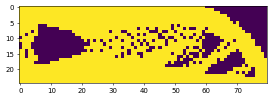

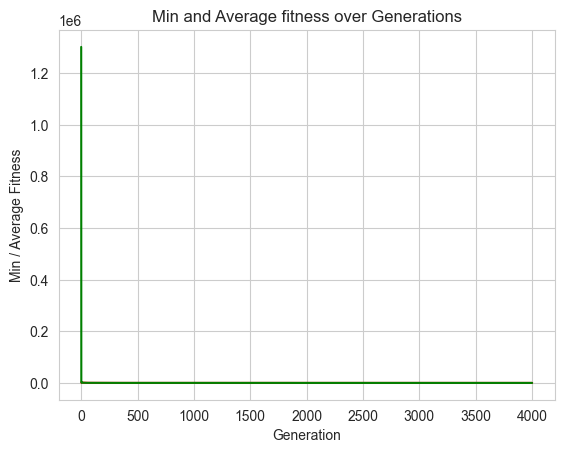

In [30]:
main()